# [Scénarios d'Exploration Statistique](https://github.com/wikistat/Exploration)
# Imputations de données manquantes avec R

**Résumé** : Exemples d'[imputation de données manquantes](http://wikistat.fr/pdf/st-m-app-idm.pdf) sous R, sur deux jeux de données. Un premier dont les variables sont toutes quantitatives puis un deuxième avec des variables quantitatives et qualitatives. Plusieurs méthodes sont comparées, la robustesse des méthodes qui donne les meilleurs résultats est analysée en augmentant progressivement le taux de données manquantes.

## 1. Objectif
Tester des méthodes d'imputation de données manquantes sur des cas-types faciles à aborder. Comparer la précision des méthodes et la robustesse des meilleures. On commencera par un jeu de données quantitatif sur lesquelles toutes les méthodes d'imputation peuvent être testées. Nous passerons dans un second temps à des données hétérogènes, plus fréquemment rencontrées en cas concret.

## 2. Données Quantitatives
On s'intéresse dans un premier temps à un jeu de données quantitatives sur lesquelles on va pouvoir comparer un maximum de méthodes d'imputation. Ce jeu de données regroupe le [cours des actifs boursiers](http://Wikistat.fr/pdf/st-scenar-explo-bourse.pdf) sur la place de Paris de 2000 à 2005. On considère 349 cours d'entreprises ou indices régulièrement cotés sur cette période. 

Les données sont disponibles dans le fichier [Paris.dat](http://Wikistat.fr/data/Paris2005.dat); les charger avant d'exécuter les lignes de code R.

### 2.1. Lecture des données

In [1]:
# lecture des données
dat=read.table("Paris2005.dat")

A noter que la plupart des méthodes d'imputation font des hypothèses de normalité. Une transformation des variables est souvent nécessaire :

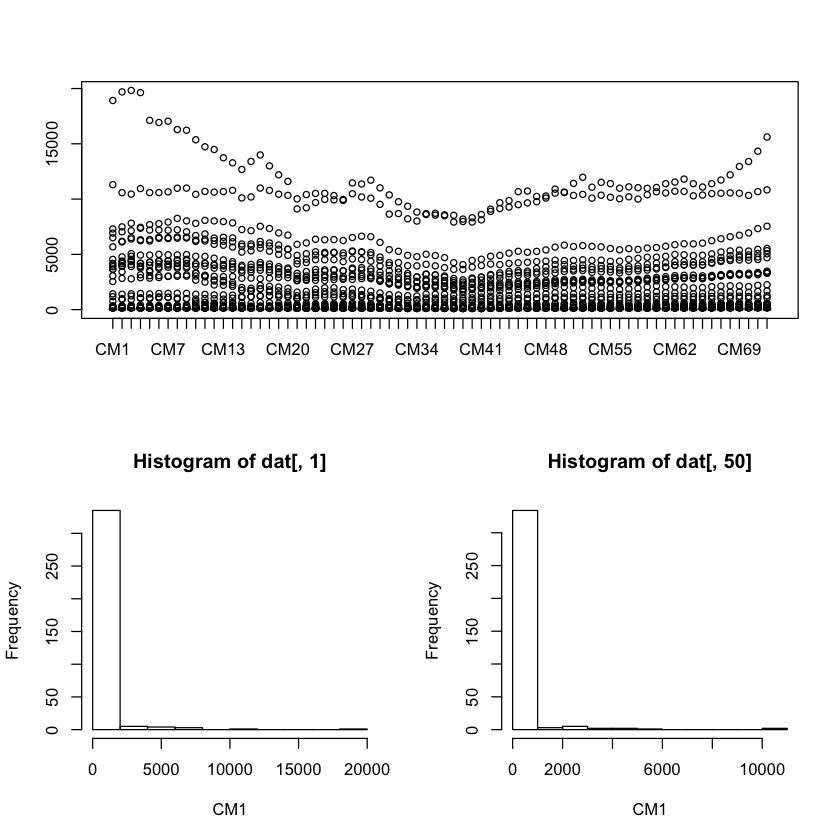

In [2]:
# Les données ne sont visiblement pas gaussiennes :
layout(matrix(c(1,1,2,3),ncol=2,byrow=T))
boxplot(dat)
hist(dat[,1],xlab=names(dat)[1])
hist(dat[,50],xlab=names(dat)[1])

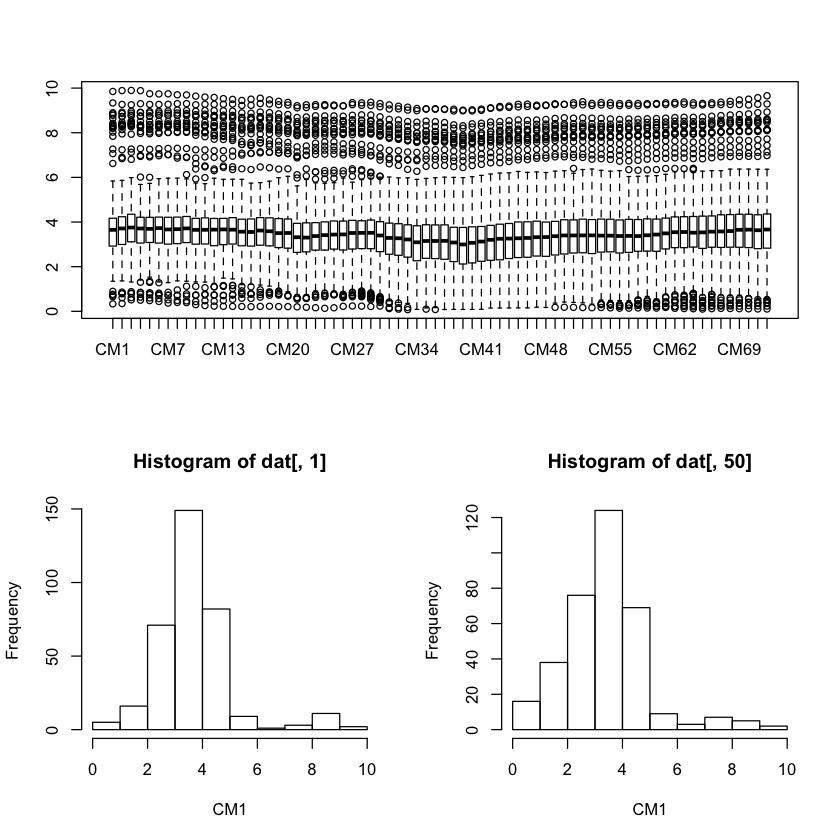

In [3]:
# Passage au log pour s'en approcher :
dat=log(dat+1)

# Vérification visuelle :
layout(matrix(c(1,1,2,3),ncol=2,byrow=T))
boxplot(dat)
hist(dat[,1],xlab=names(dat)[1])
hist(dat[,50],xlab=names(dat)[1])

## 2.2 Création de données manquantes
En se limitant au cas MCAR, on crée artificiellement des données manquantes.  On pourra ensuite comparer les résultats de la complétion avec les données retirées.

In [4]:
# initialisation du générateur
set.seed(42) 
# Ratio de données manquantes
test.ratio=0.1
# Indices de l'échantillon test
IND=which(!is.na(dat),arr.ind=TRUE)
ntest=ceiling(dim(dat)[1]*test.ratio)
ind.test=IND[sample(1:dim(IND)[1],ntest),]
# Création des données manquantes
dat.test=dat[ind.test]
dat.train=dat
dat.train[ind.test]=NA 

## 2.3 Imputation
### 2.3.1 LOCF

In [5]:
# chargement de la bibliothèque
if(!("zoo" %in% rownames(installed.packages())))install.packages("zoo")
suppressMessages(library(zoo))
dat.locf=na.locf(dat.train,na.rm=FALSE)
dat.locf=na.locf(dat.locf,na.rm=FALSE,
   fromLast=TRUE)
# calcul de l'erreur
err.locf=abs(dat.test-dat.locf[ind.test])

## 2.3.2 Par la moyenne

In [6]:
# chargement de la bibliothèque
if(!("Hmisc" %in% rownames(installed.packages())))install.packages("Hmisc")
suppressMessages(library(Hmisc))
dat.moy=impute(dat.train, fun=mean)
err.moy=abs(dat.test-as.matrix(dat.moy)[ind.test])

### 2.3.3 Par la médiane

In [7]:
med=apply(dat.train,1,median,na.rm=TRUE)
dat.med=dat.train
ind.na=which(is.na(dat.med),arr.ind=TRUE)
dat.med[ind.na]=med[ind.na[,1]]
err.med=abs(dat.test-dat.med[ind.test])

### 2.3.4 K plus proches voisins

In [8]:
if(!("VIM" %in% rownames(installed.packages())))install.packages("VIM")
suppressMessages(library(VIM))
dat.kNN=kNN(dat.train, k=5, imp_var=FALSE)
err.kNN=abs(dat.test-dat.kNN[ind.test])

### 2.3.5 LOESS

In [9]:
if(!("locfit" %in% rownames(installed.packages())))install.packages("locfit")
suppressMessages(library(locfit))
dat.imputed=rbind(colnames(dat.train),dat.train)
indices=1:nrow(dat.train)
dat.loess= apply(dat.imputed, 2, function(j) {
  predict(locfit(j[-1] ~ indices), indices)
})
err.loess=abs(dat.test-dat.loess[ind.test])

### 2.3.6 SVD

In [10]:
# chargement de la bibliothèque
if(!("bcv" %in% rownames(installed.packages())))install.packages("bcv")
suppressMessages(library(bcv))
dat.SVD=impute.svd(dat.train,k=3,maxiter=1000)$x
err.svd=abs(dat.test-dat.SVD[ind.test])

### 2.3.7 missForest

In [11]:
# chargement de la bibliothèque
if(!("missForest" %in% rownames(installed.packages())))install.packages("missForest")
suppressMessages(library(missForest))
dat.mF<-missForest(dat.train,maxiter=10,ntree = 200, variablewise = TRUE)$ximp
err.mF=abs(dat.test-dat.mF[ind.test])

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!


### 2.3.8 AmeliaII

In [12]:
if(!("Amelia" %in% rownames(installed.packages())))install.packages("Amelia")
suppressMessages(library(Amelia))
dat.amelia=amelia(dat.train,m=1)$imputations$imp1
err.amelia=abs(dat.test-dat.amelia[ind.test])

-- Imputation 1 --

  1  2  3



## 2.4 Comparaison des résultats

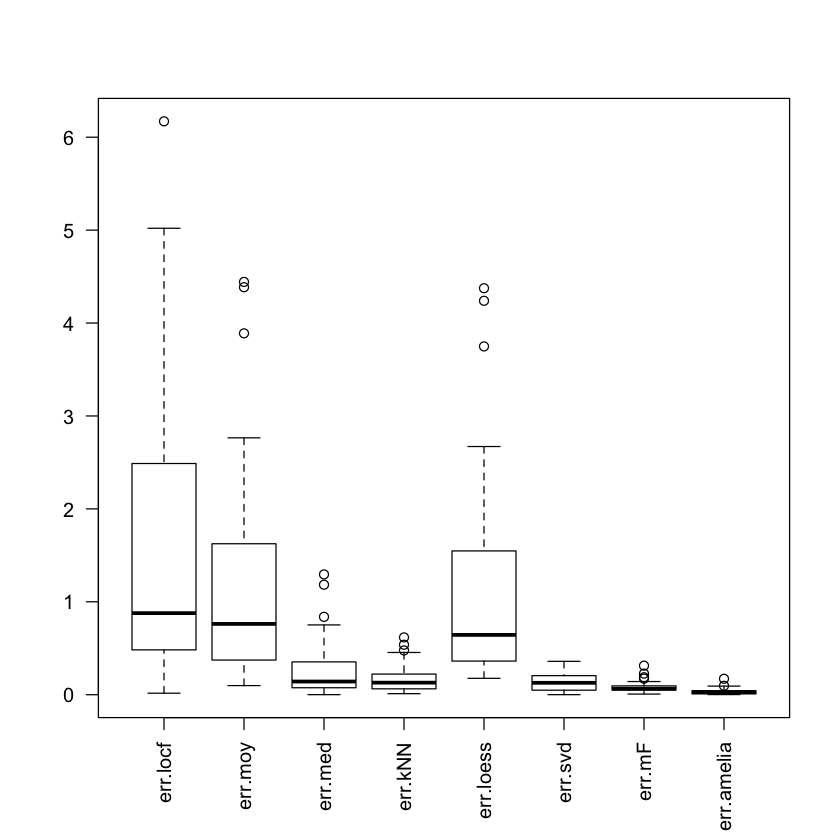

In [13]:
boxplot(data.frame(err.locf,err.moy,err.med,err.kNN,err.loess,err.svd,err.mF,err.amelia),las=2)

#### Identifier les méthodes les plus précises: SVD, missForest et AmeliaII, dont le comportement est ensuite étudié lorsque la quantité de données manquantes augmente.

### 2.5 Robustesse des méthodes

In [14]:
# de 10 à 80% de données manquantes
TEST.RATIO=seq(0.1,0.8,by=0.1)
# initialisation des matrices d'erreur
err.amelia=matrix(NA,nrow=length(TEST.RATIO),ncol=280)
err.mf=matrix(NA,nrow=length(TEST.RATIO),ncol=280)
err.svd=matrix(NA,nrow=length(TEST.RATIO),ncol=280)
tmp=1
for (test.ratio in TEST.RATIO){
  IND=which(!is.na(dat),arr.ind=TRUE)
  ntest=ceiling(dim(dat)[1]*test.ratio)
  ind.test=IND[sample(1:dim(IND)[1],ntest),]
  dat.test=dat[ind.test]
  dat.train=dat
  dat.train[ind.test]=NA 
  
  dat.amelia=amelia(dat.train,m=1)$imputations$imp1
  err.amelia[tmp,1:length(ind.test[,2])]=abs(dat.test-dat.amelia[ind.test])
  
  dat.SVD=impute.svd(dat.train,k=3,maxiter=1000)$x
  err.svd[tmp,1:length(ind.test[,2])]=abs(dat.test-dat.SVD[ind.test])
  
  dat.mf<-missForest(dat.train, maxiter=10, 
  ntree = 200, variablewise = TRUE)$ximp
  err.mf[tmp,1:length(ind.test[,2])]=abs(dat.test-dat.mf[ind.test])
  
  tmp=tmp+1
}

-- Imputation 1 --

  1  2  3

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
-- Imputation 1 --

  1  2  3  4

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 5 in progress...done!
  missForest iteration 6 in progress...done!
  missForest iteration 7 in progress...done!
  missForest iteration 8 in progress...done!
-- Imputation 1 --

  1  2  3

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
-- Imputation 1 --

  1  2  3  4  5  6  7  8  9 10 11 12 13 14

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in pr

[1] 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8

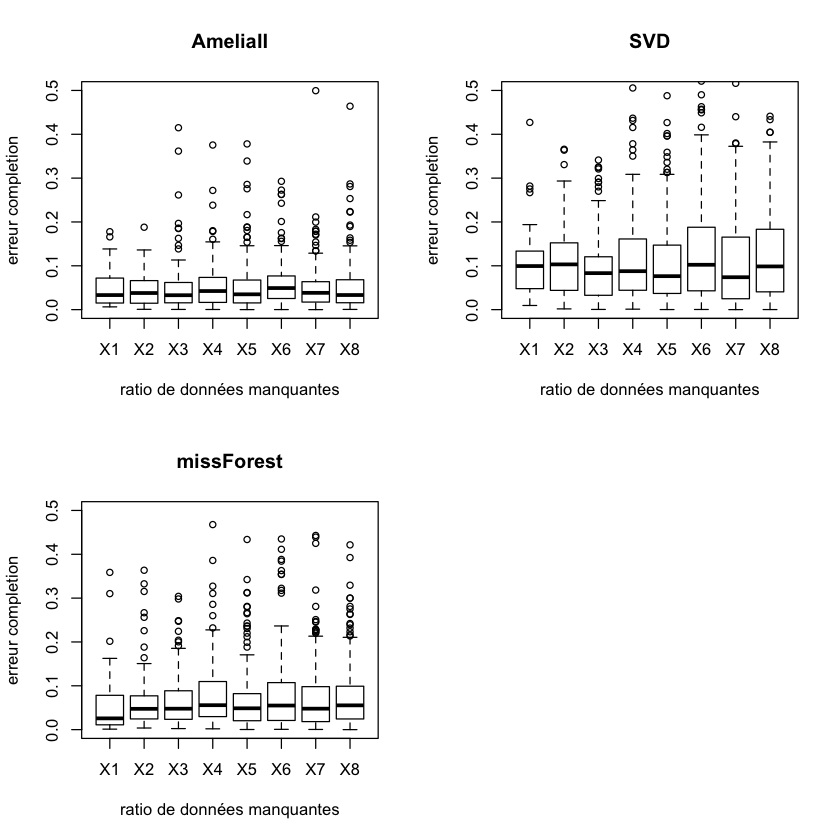

In [15]:
# Affichage des erreurs
# ratio de données manquantes en abscisse
TEST.RATIO
par(mfrow=c(2,2))
boxplot(
  data.frame(t(err.amelia)),
  na.action=na.omit,ylim=c(0,0.5),
  xlab="ratio de données manquantes",
  ylab="erreur completion",
  main="AmeliaII"
)
boxplot(
  data.frame(t(err.svd)),na.action=na.omit,
  ylim=c(0,0.5),xlab="ratio de données manquantes",
  ylab="erreur completion",
  main="SVD"
)
boxplot(
  data.frame(t(err.mf)),na.action=na.omit,
  ylim=c(0,0.5),xlab="ratio de données manquantes",
  ylab="erreur completion",
  main="missForest"
)

Comparer les résultats. Si AmeliaII semble donner les meilleurs résultats, remarquer que l'erreur de complétion reste relativement stable pour les trois méthodes présentées malgré l'augmentation du taux de valeurs manquantes.

## 3. Données hétérogènes
Si la plupart des méthodes de complétion privilégient les données quantitatives, certaines peuvent être utilisées pour imputer des données qualitatives voire hétérogènes (*i.e.* un mélange de données qualitatives et quantitatives). Nous développerons cette possibilité en utilisant un jeu de données hétérogène propice à l'imputation.

Les données ont été acquises par [Detrano et al. (1989)](http://www.ajconline.org/article/0002-9149%2889%2990524-9/abstract) et mises à disposition par [Bache et Lichman (2013)](https://scholar.google.com/citations?view_op=view_citation&hl=fr&user=RSMBQOgAAAAJ&citation_for_view=RSMBQOgAAAAJ:zYLM7Y9cAGgC). On considère donc un ensemble de 270 relevés médicaux liés à la présence de maladie coronarienne. Sur les 14 variables relevées, 5 sont des variables quantitatives (age, pression, cholestérol, fréquence cardiaque maximale, *oldpeak*) et 9 sont qualitatives (sexe, douleur, sucre, cardio, angine, pente du pic, nombre de vaisseaux cardiaques, thalassémie,présence de maladie cardiaque). 

### 3.1 Lecture des données
La lecture des données nécessite un pré-traitement afin de définir les variables qualitatives comme des facteurs :

In [16]:
# Lecture des données
heart=read.table("heart.dat")

# recodage des classes et nom des variables
heart=data.frame(
    Age=heart[,1],
    Sexe=factor(as.factor(heart[,2]),labels=c("sxF","sxM")),
    Douleur=factor(as.factor(heart[,3]),labels=c("dlA","dlB","dlC","dlD")),
    Pression=heart[,4],
    Cholest=heart[,5],
    Sucre=factor(as.factor(heart[,6]),labels=c("scN","scO")),
    Cardio=factor(as.factor(heart[,7]),labels=c("cdA","cdB","cdC")),
    Taux_max=heart[,8],
    Ang_ind=factor(as.factor(heart[,9]),labels=c("tmA","tmB")),
    Pic_ind=heart[,10],
    Pente_ind=factor(as.factor(heart[,11]),labels=c("piA","piB","piC")),
    Nvais=factor(as.factor(heart[,12]),labels=c("flA","flB","flC","flD")),
    Thal=factor(as.factor(heart[,13]),labels=c("thN","thF","thR")),
    Classe=factor(as.factor(heart[,14]),labels=c("hdA","hdP"))
)

### 3.2 Comparaison de méthodes d'imputation
LOCF, kNN et missForest sont trois méthodes de complétion qui permettent d'imputer des données hétérogènes.  Ces méthodes sont testées et comparées entre elles au fur et à mesure que la quantité de données manquantes augmente. L'erreur d'imputation des données quantitatives est calculée comme précédemment, c'est à dire que l'on prendra la valeur absolue de la différence avec l'échantillon test. Pour les variables qualitatives, on utilisera la distance de Hamming définie par
$$err=100*\frac{\sum_i \mathbb{1}_{x_i^* \neq x_i^{test}}}{\# x_i^{test}}$$
avec $x_i^{test}$ la valeur de test et $x_i^*$ la valeur imputée.

Dans R, on définit la fonction d'erreur par :

In [17]:
err.model<-function(heart,heart.model,ind.test){
err={}
for (i in sort(unique(ind.test[,2]))){
    test=heart[ind.test[ind.test[,2]==i,1],i]
    if (length(test)>0){
        if (is.factor(heart[,i])){
            #distance de Hamming (pourcentage de mauvais choix)
            err=rbind(err,100*length(which(heart.model[,i]!=heart[,i]))/length(test))
        } else {
            #moyenne de l'erreur en valeur absolue
            err=rbind(err,mean(abs(as.numeric(heart[ind.test[ind.test[,2]==i,1],i])-as.numeric(heart.model[ind.test[ind.test[,2]==i,1],i])))) 
        }
    }
}
err
}

### 3.3 Création de données manquantes
En se limitant toujours au cas MCAR, on crée artificiellement de plus en plus de données manquantes à imputer : de 10 à 80%, ratio donné par `TEST.RATIO`. On initialise les matrices d'erreur, une ligne par ratio de données manquantes, une colonne par variable :

In [18]:
TEST.RATIO=seq(0.1,0.8,by=0.1)
# initialisation des matrices d'erreur
err.locf=matrix(NA,nrow=length(TEST.RATIO),ncol=14)
colnames(err.locf)=names(heart)
err.kNN=matrix(NA,nrow=length(TEST.RATIO),ncol=14)
colnames(err.kNN)=names(heart)
err.missForest=matrix(NA,nrow=length(TEST.RATIO),ncol=14)
colnames(err.missForest)=names(heart)
err.amelia=matrix(NA,nrow=length(TEST.RATIO),ncol=14)
colnames(err.amelia)=names(heart)

### 3.4 Imputation

In [19]:
for(test.ratio in TEST.RATIO){
  # création de l'échantillon test
  IND=which(!is.na(heart),arr.ind=TRUE)
  ntest=ceiling(dim(heart)[1]*test.ratio)
  ind.test=IND[sample(1:dim(IND)[1],ntest),]
  heart.test=heart[ind.test]
  heart.train=heart
  heart.train[ind.test]=NA 
  
  # par LOCF
  heart.locf=na.locf(heart.train,na.rm=FALSE)
  heart.locf=na.locf(heart.locf,na.rm=FALSE,fromLast=TRUE)
  err.locf[,1:length(unique(ind.test[,2]))]=err.model(heart,heart.locf,ind.test)
  
  # par kNN
  heart.kNN=kNN(heart.train, k=5, imp_var=FALSE)
  err.kNN[,1:length(unique(ind.test[,2]))]=err.model(heart,heart.kNN,ind.test)
  
  # par missForest
  heart.missForest<-missForest(heart.train,maxiter=10,ntree=200,variablewise=TRUE)$ximp
  err.missForest[,1:length(unique(ind.test[,2]))]=err.model(heart,heart.missForest,ind.test)
}

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 5 in progress...done!
  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 5 in progress...done!
  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missFore

### 3.5 Comparaison des résultats
Pour une variable quantitative et une variable qualitative, on affiche l'évolution de l'erreur avec la proportion de données manquantes.

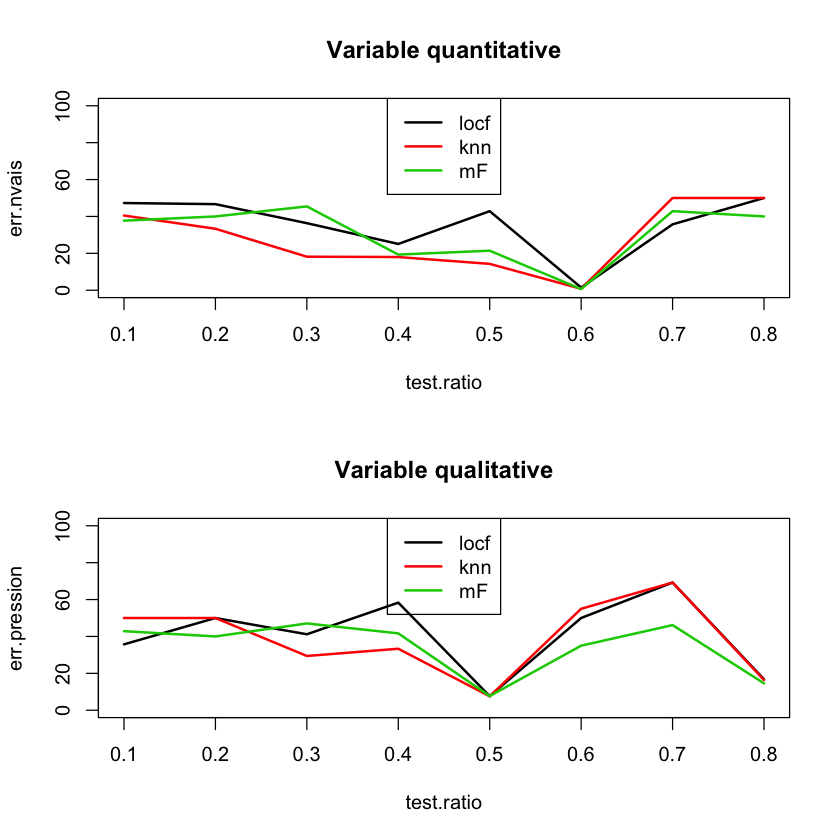

In [20]:
err.pression=cbind(err.locf[,4],err.kNN[,4],err.missForest[,4])
err.nvais=cbind(err.locf[,12],err.kNN[,12],err.missForest[,12])

par(mfrow=c(2,1))
matplot(TEST.RATIO,err.nvais,type='l',lwd=2,lty=1,col=1:3,xlab="test.ratio",main="Variable quantitative",ylim=c(0,100))
legend("top",legend=c("locf","knn","mF"),col=1:3,lwd=2,lty=1)
matplot(TEST.RATIO,err.pression,type='l',lwd=2,lty=1,col=1:3,xlab="test.ratio",main="Variable qualitative",ylim=c(0,100))
legend("top",legend=c("locf","knn","mF"),col=1:3,lwd=2,lty=1)

Comparer les  erreurs de complétion sur l'échantillon test par LOCF, KNN et missForest quand la quantité de valeurs manquantes augmente, pour une variable qualitative et une quantitative.

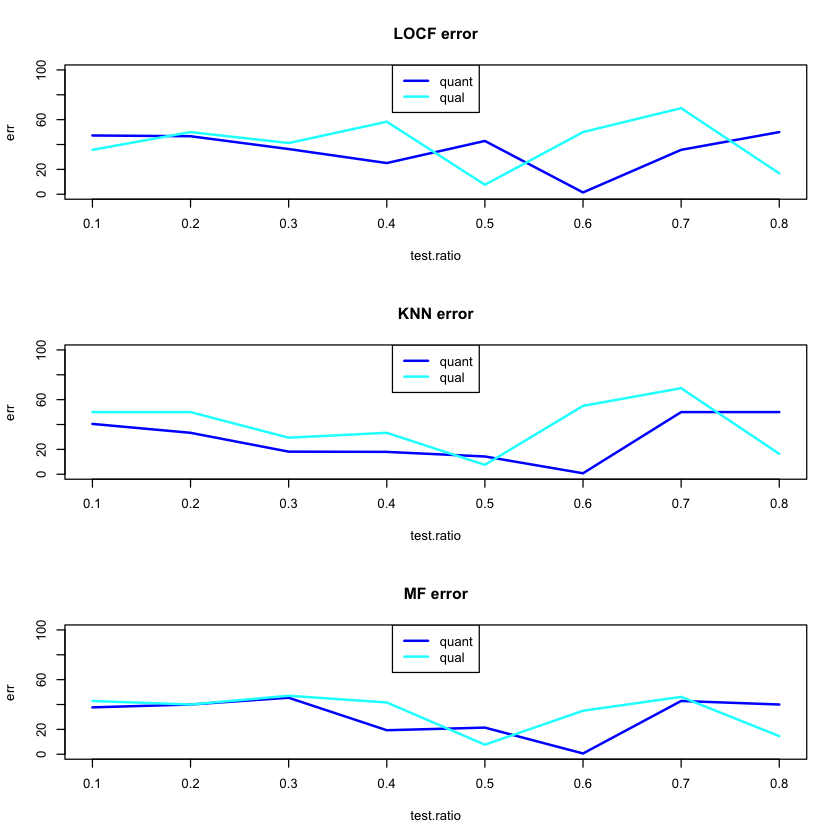

In [21]:
par(mfrow=c(3,1))
matplot(TEST.RATIO,data.frame(err.nvais[,1],err.pression[,1]),type='l',lwd=2,lty=1,col=4:5,ylab="err",xlab="test.ratio",main="LOCF error",ylim=c(0,100))
legend("top",legend=c("quant","qual"),col=4:5,lwd=2,lty=1)

matplot(TEST.RATIO,data.frame(err.nvais[,2],err.pression[,2]),type='l',lwd=2,lty=1,col=4:5,ylab="err",xlab="test.ratio",main="KNN error",ylim=c(0,100))
legend("top",legend=c("quant","qual"),col=4:5,lwd=2,lty=1)

matplot(TEST.RATIO,data.frame(err.nvais[,3],err.pression[,3]),type='l',lwd=2,lty=1,col=4:5,ylab="err",xlab="test.ratio",main="MF error",ylim=c(0,100))
legend("top",legend=c("quant","qual"),col=4:5,lwd=2,lty=1)